In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc3 as pm


from ipywidgets import interact
import ipywidgets as ipyw

In [52]:
az.style.use('arviz-whitegrid')

In [53]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [57]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False"});

##### <center><img src="img/logo_inst.png" width="750">
<br>
<br>
<br>
<br>
<h1 align="center">Modelado probabilístico, si es Bayes es bueno</h1> 
<h2 align="center">Hierarchical models</h2> 
    


<br>
<br>
<br>
<br>
<br>
<h4 align="center">
Buenos Aires, junio 2019
</h4> 

## Hierarchical models

<center>
<img src="img/pooling.png" width=500>

In [ ]:
(1) Improved estimates for repeat sampling. When more than one observation arises
from the same individual, location, or time, then traditional, single-level models
either maximally underfit or overfit the data.
(2) Improved estimates for imbalance in sampling. When some individuals, locations, or
times are sampled more than others, multilevel models automatically cope with dif-
fering uncertainty across these clusters. This prevents over-sampled clusters from
unfairly dominating inference.
(3) Estimates of variation. If our research questions include variation among individu-
als or other groups within the data, then multilevel models are a big help, because
they model variation explicitly.
(4) Avoid averaging, retain variation. Frequently, scholars pre-average some data to
construct variables. This can be dangerous, because averaging removes variation,
and there are also typically several different ways to perform the averaging. Aver-
aging therefore both manufactures false confidence and introduces arbitrary data
transformations. Multile

## Aims

*
*

### Veamos otro ejemplo 


Las [proteínas](https://www.youtube.com/watch?v=wvTv8TqWC48) son moléculas formadas por 20 unidas, llamadas amino ácidos, cada amino ácido puede aparecer en una proteína 0 o más veces. Así como una melodía está definida por una sucesión de notas musicales, una proteína está definida por una sucesión de amino ácidos. Algunas variaciones de notas pueden dar como resultados pequeñas variaciones sobre la misma melodía, otras variaciones pueden resultar en melodías completamente distintas, algo similar sucede con las proteínas. Una forma de estudiar proteínas es usando resonancia magnética nuclear (la misma técnica usada para imágenes médicas). Esta técnica permite medir diversos _observables_, uno de ellos se llama _desplazamiento químico_ y para simplificar diremos que podemos medir tantos desplazamientos químicos como amino ácidos tenga una proteína. Los aminoácidos son una familia de compuestos químicos por lo que tendría sentido tratarlos a todos de igual forma, pero al mismo tiempo tienen diferentes propiedades químicas, las cuales de hecho son relevantes para comprender como funcionan las proteínas! Por lo que también tiene sentido tratarlos por separado. Como ya vimos una alternativa es construir un modelo jerárquico y hacer algo a mitad de camino.

El siguiente conjunto de datos contiene valores de desplazamientos químicos para un conjunto de proteínas. Si inspeccionan el DataFrame `cs_data` verán que tiene 4 columnas:

* La primera es un código que identifica a la proteína (pueden obtener muchísima información sobre esa proteína ingresando ese código en https://www.rcsb.org/.).
* La segunda columna tiene el nombre del amino ácido (pueden corroborar que hay tan solo 20 nombres únicos).
* La tercera contiene valores téoricos de desplazamientos químicos (calculados usando métodos cuánticos).
* La cuarta tiene valores experimentales.

La motivación de este ejemplo es comparar las diferencias entre valores teóricos y experimentales, entre otras razones para evaluar la capacidad de los métodos cuánticos para reproducir valores experimentales.


In [47]:
cs_data = pd.read_csv('datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))

cs_data.tail()

,ID,aa,theo,exp
1771,1KS9,LYS,55.79,57.51
1772,1KS9,ARG,58.91,59.02
1773,1KS9,LYS,59.49,58.92
1774,1KS9,GLU,59.48,58.36
1775,1KS9,SER,58.07,60.55


Para resaltar la diferencia entre un modelo jerárquico y uno no-jerárquico vamos a construir ambos. Primero el no-jerárquico.

In [48]:
with pm.Model() as cs_nh:         
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups) 
    σ = pm.HalfNormal('σ', sd=10, shape=groups) 
 
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff) 
     
    trace_cs_nh = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 560.51draws/s]


Y ahora el jerárquico.

Este modelo tiene un hyper-prior para la media de $\mu$ y otro para la desviación estándar de $\mu$. Para $\sigma$ no usamos un hyper-prior, es decir asumimos valores independientes. Esta es una decisión que tomé para simplificar el modelo, en principio no habría problema con usar un hyper-prior también para $\sigma$ o incluso  estimar un solo valor, compartido, de $\sigma$.

In [49]:
with pm.Model() as cs_h:
    # hyper_priors
    μ_mu = pm.Normal('μ_mu', mu=0, sd=10)
    μ_sd = pm.HalfNormal('μ_sd', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_mu, sd=μ_sd, shape=groups) 
    σ = pm.HalfNormal('σ', sd=10, shape=groups) 

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff) 

    trace_cs_h = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ, μ_sd, μ_mu]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 493.48draws/s]


Vamos a comparar los resultados usando un `plot_forest`. ArviZ permite pasar más de un modelo. Esto es útil cuando queremos comparar los valores de parámetros equivalentes entre modelos como en el presente ejemplo. Noten que estamos pasando varios argumentos para obtener el gráfico, como por ejemplo `combined=True` que combina los resultados de todas las cadenas. Los invito a explorar el significado del resto de los parámetros.

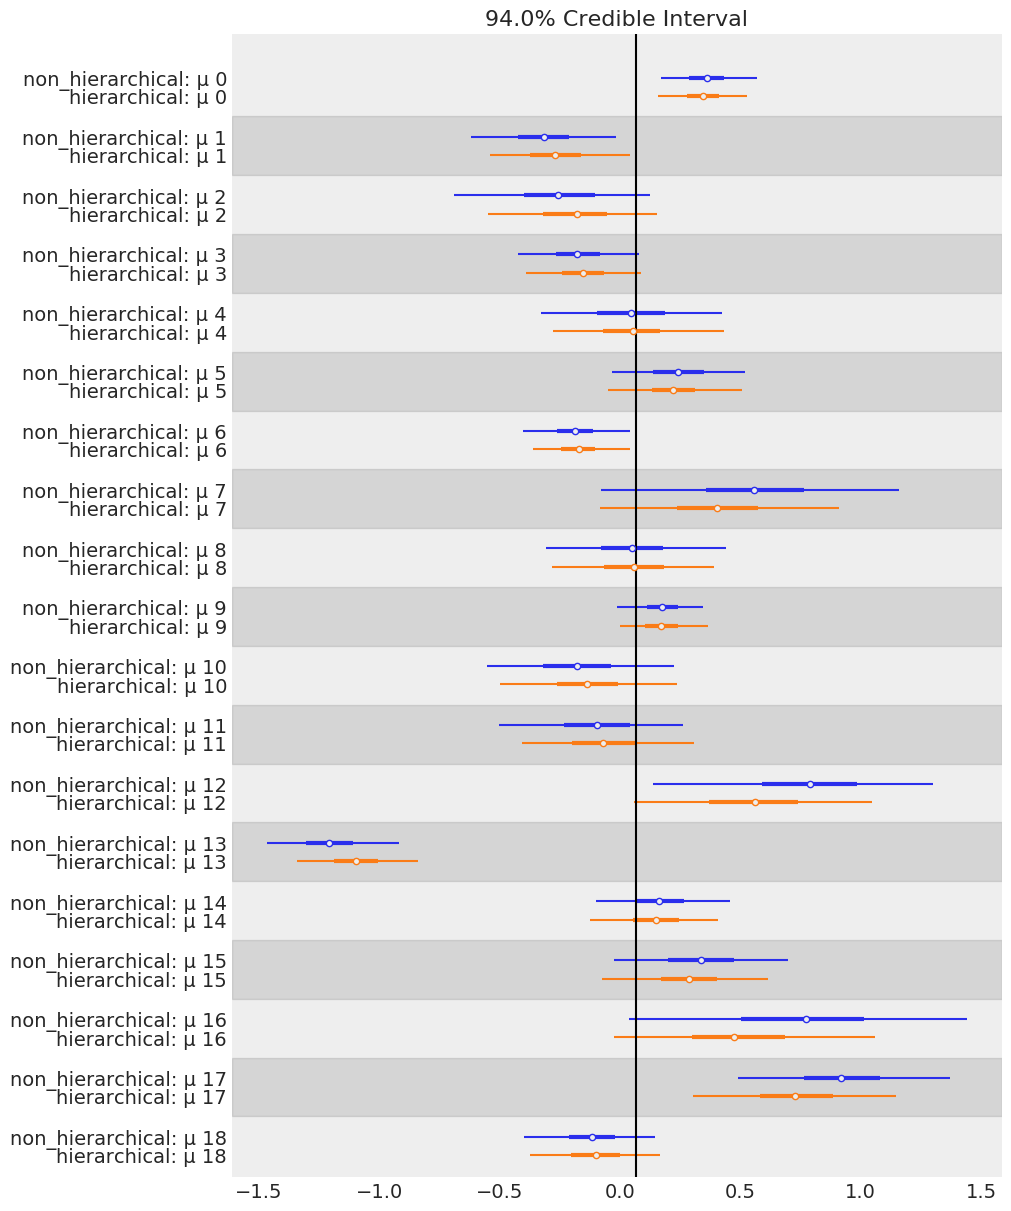

In [50]:
_, axes = az.plot_forest([trace_cs_nh, trace_cs_h], model_names=['non_hierarchical', 'hierarchical'],
              var_names='μ', combined=True, r_hat=False, ess=False, figsize=(10, 12),
              colors='cycle');
y_lims = axes[0].get_ylim()
axes[0].vlines(trace_cs_h['μ_mu'].mean(), *y_lims);

Bien, tenemos un gráfico para 40 valores medios estimados, uno por aminoácido (20) y esto duplicado ya que tenemos dos modelos. También tenemos los intervalos de credibilidad del 94% y el rango intercuartil (el intervalo que contiene el 50% central de la distribución). La línea vertical es la media parcialmente agrupada, es decir la media según el modelo jerárquico. El valor es cercano a cero, esto es parte de lo que esperaríamos ver si los valores teóricos son buenos reproduciendo los valores experimentales. 

La parte más relevante de este gráfico es que las estimaciones del modelo jerárquico son _atraidas_ hacia la media parcialmente agrupada o, de forma equivalente, se _contraen_ con respecto a las estimaciones no agrupadas. Este efecto es más notorio para los grupos más alejados de la media (como 13), además la incertidumbre es igual o menor que la del modelo no jerárquico. Decimos que las estimaciones están parcialmente agrupadas porque tenemos una estimación para cada grupo, pero las estimaciones para cada grupos se restringen mutuamente mediante el hiper prior. Por lo tanto, se obtiene una situación intermedia entre tener un solo grupo, todos los aminoácidos juntos, y tener 20 grupos separados, uno por aminoácido. 

Parafraseando el Zen de Python, podemos decir: _hierarchical models are one honking great idea - let's do more of those!_.

En los próximos capítulos, seguiremos construyendo modelos jerárquicos y aprendiendo cómo usarlos para construir mejores modelos. También discutiremos cómo se relacionan los modelos jerárquicos con uno de los problemas más comunes en estadística, ciencia de datos y _Machine learning_ el problema del overfitting/underfitting.

## Modelos Jerárquicos

El siguiente ejemplo está tomado del capítulo 9 del libro "Doing Bayesian Data Analysis" de John K. Kruschke. Supongamos que en vez de 1 moneda tenemos 3, supongamos además que sabemos que las tres monedas fueron echas con la misma matriz (en la misma fábrica). Para estimar el valor de $\theta$ tenemos dos opciones:

1) estimar un valor de $\theta$ para cada moneda por separado.

2) juntar las tres monedas en un mismo conjunto de datos y calcular un solo valor de $\theta$

La ventaja de la opción 1 es que las monedas podrían diferir entre sí por lo que calcular 3 valores de  $\theta$ podría ser muy informativo. La desventaja de este modelo es que hace caso omiso a la información que indica que las 3 monedas tienen un origen común, por lo que es probable que compartan características.

La ventaja de la opción 2 es que la cantidad de datos por parámetro aumentó, lo que reduce la incerteza. El problema es que pasamos a asumir que las 3 monedas son en realidad una, lo cual no sería problemático si las tres monedas fueran muy similares entre sí, pero esto podría no ser una buena aproximación.

Una tercera opción es hacer algo a mitad de camino entre 1 y 2. Esto se consigue construyendo un modelo jerárquico o modelo multinivel. Este tipo de modelo nos permitirá estimar un valor de $\theta$ para cada moneda de forma tal que la estimación de cada valor de $\theta$ influencie al resto.

En estadística Bayesiana construir modelos jerárquicos es sencillo. A continuación veremos que un modelo jerárquico para las 3 monedas es muy similar al usado para el caso de 1 sola moneda, solo que ahora colocamos un _a priori_ ¡sobre el _a priori_!

Recordemos, el modelo del capítulo anterior era:

\begin{align}
\theta &\sim \operatorname{Beta}(\alpha, \beta) \\
y &\sim \operatorname{Bin}(n=1, p=\theta)
\end{align}

En un modelo jerárquico los argumentos de la distribución Beta ($\alpha$ y $\beta$) no son constantes si no que son valores que proviene de alguna otra distribución. En nuestro modelo tendremos que:

\begin{align}
\mu &\sim \operatorname{Beta}(\alpha, \beta) \\
\kappa &\sim \operatorname{Gamma}(s, r) \\
\theta &\sim \operatorname{Beta}(\alpha=\mu  \kappa, \beta=(1 - \mu)  \kappa) \\
y &\sim \operatorname{Bin}(n=1, p=\theta)
\end{align}


Gráficamente, tenemos:

<img src="img/modelo_3_monedas_jerarquico.png" width=250>

En los modelos jerárquicos a los parámetros $\mu$ y a $\kappa$ se los llama _hiper a prioris_ o _hiperparámetros_ ya que son ellos quienes determinan el valor del _a priori_. La diferencia entre el modelo del capítulo anterior y el del presente es que ahora los valores que puede tomar $\theta$ dependen no ya de una distribución fija ($\alpha=1$ y $\beta=1$) si no de una distribución que depende de los valores de $\mu$ y $\kappa$, y que estimaremos a partir de los datos. Es decir es posible estimar el _a priori_ a partir de los datos, pero solo por que hemos introducido _hiper a prioris_. 

Recordarán que la distribución Beta se podía parametrizar en términos de $\alpha$ y $\beta$, pero también de $\mu$  y $\kappa$, donde $\mu$ es la media y $\kappa$ es la concentración (la inversa de la dispersión). Tenemos entonces que $\mu$ reflejará el valor promedio de 3 valores de $\theta$ y que si la proporción de caras en las tres monedas es similar entre si $\kappa$ tomara un valor más alto; mientras que si las monedas son diferentes entre si $\kappa$ tomará un valor más bajo.

### ¿Por qué la elección de los hiper _a prioris_?

Bueno dado que $\mu$ es la media del vector $\theta$ (y que $\theta$ solo puede tomar valores entre 0 y 1), $\mu$ queda restringida a valores entre 0 y 1 (al igual que una distribución beta), siguiendo el mismo razonamiento $\kappa$ va entre $[0, \infty]$ al igual que la distribución gamma. Otras distribuciones igualmente razonables podrían haber sido:

* $ \mu \sim U(0, 1)$
* $ \kappa \sim \mathcal{HN}(\sigma=100)$


Primero que nada generemos algunos datos sintéticos y los pondremos de una forma que sea más simple pasárselos al modelo, esto quedará un poco más claro al la especificación del modelo.

Vamos a suponer que con cada una de las 3 monedas hicimos 10 experimentos de Bernoulli (las arrojamos al aire) y obtuvimos como resultado, para cada caso, 5 caras.

In [41]:
N =  [10, 10, 10]  # Número de experimentos por moneda
z =  [5, 5, 5]  # [1, 5, 9]  # Número de caras en los Ni experimentos.

# vector conteniendo los índices para cada moneda (desde 0 al número de monedas)
monedas = np.repeat(np.arange(len(N)), N)
# lista con 1 para caras y 0 para cecas
datos = []  
for i, experimentos in enumerate(N):
    datos.extend(np.repeat([1, 0], [z[i], N[i]-z[i]]))

Como no sabemos demasiado sobre $\mu$ y $\kappa$, vamos a elegir $ \mu \sim \operatorname{Beta}(\alpha=2, \beta=2)$, lo que equivale a una distribución centrada en 0.5, pero que casi asigna la misma probabilidad a todos los valores entre 0 y 1. Y $ \kappa = \operatorname{Gamma}(s=1, r=0.1)$, lo que equivale a una curva con media y  desviación estándar 10.

La especificación del modelo es igual a lo que hemos venido haciendo, la única diferencia es que en la linea 8 podemos observar que hay un argumento llamando _shape_. Esto nos permite especificar las dimensiones de (en este caso) _$\theta$_. PyMC3 permite escribir modelos _vectorizados_ ahorrándonos el tener que escribir _for loops_. Esa es la razón por la cual en la celda superior creamos un vector _monedas_ que usamos en la linea 10 (de la especificación del modelo) para indexar _theta_.

In [42]:
with pm.Model() as modelo_j:
    # definimos los hiperparámetros
    μ = pm.Beta('μ', alpha=2, beta=2)
    κ = pm.Gamma('κ', alpha=1, beta=0.1)
    #κ = pm.Gamma('κ', mu=10, sd=10)
    
    # definimos el a priori
    θ = pm.Beta('θ', μ * κ, (1 - μ) * κ, shape=len(N))
    # definimos el likelihood
    y = pm.Bernoulli('y', p=θ[monedas], observed=datos)

    # muestreamos
    trace_j = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ, κ, μ]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:05<00:00, 984.90draws/s] 


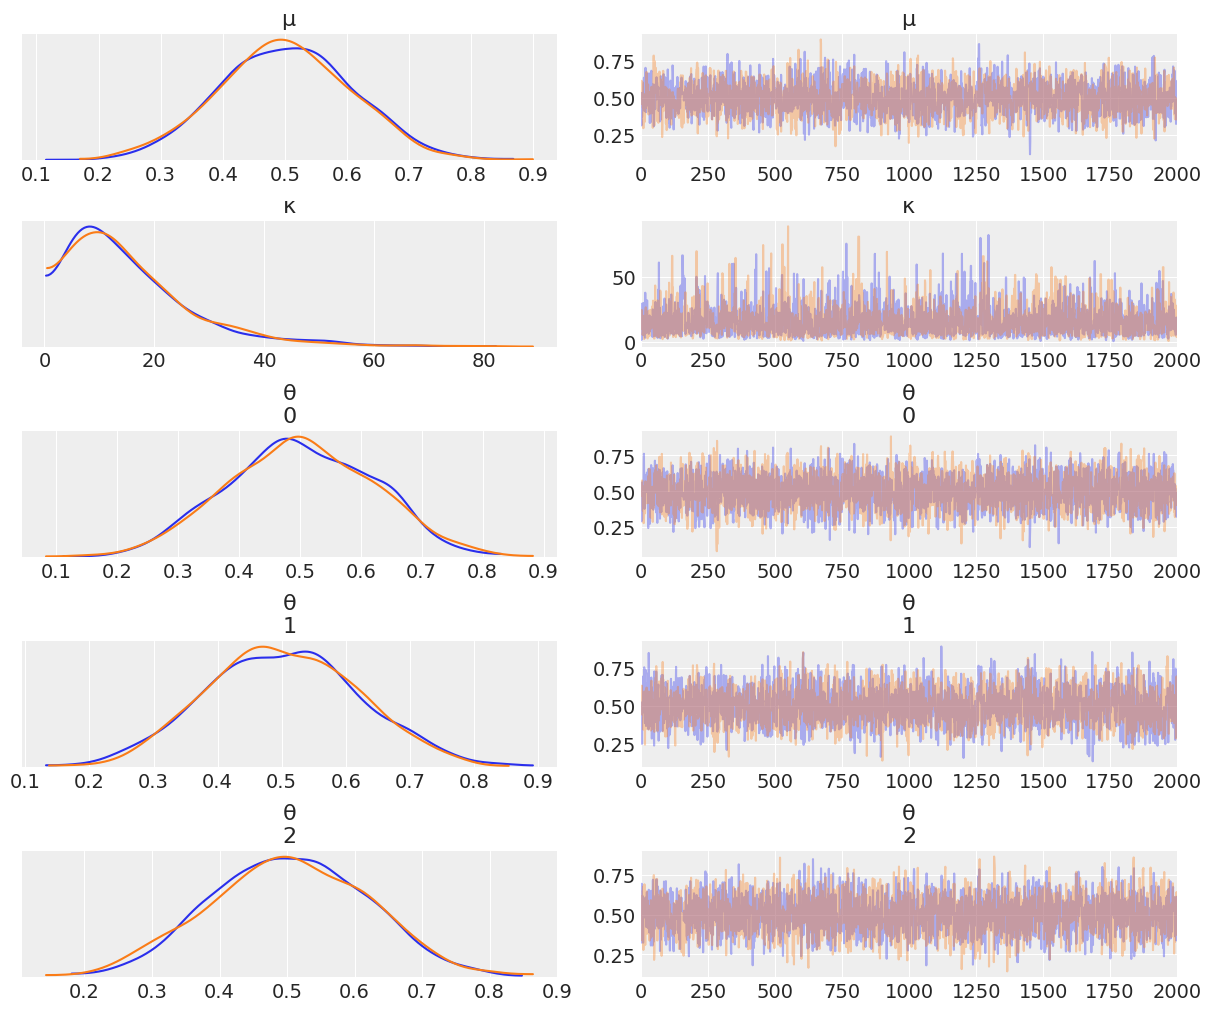

In [43]:
az.plot_trace(trace_j);

In [44]:
# az.plot_autocorr(trace_j);

In [45]:
pm.summary(trace_j)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
μ,0.499998,0.105521,0.001958,0.296073,0.702849,2399.906954,1.000288
κ,16.068606,12.025640,0.265281,0.838756,39.952220,2102.010979,0.999911
θ__0,0.499394,0.118687,0.002080,0.273370,0.725566,3193.841254,0.999809
θ__1,0.500473,0.117866,0.002216,0.266088,0.717955,2744.103374,0.999753
θ__2,0.501673,0.115583,0.001976,0.268994,0.712785,3081.686999,0.999791


Podemos observar que el valor de $\kappa$ del _a posteriori_ es mayor que del _a priori_. Esto es razonable ya que los experimentos con las 3 monedas han resultado idénticos, indicando que la matriz tiene un efecto importante sobre el resultado de $\theta$ para cada moneda.

¿Qué distribución hubiéramos obtenido para $\kappa$ si las monedas hubieran mostrado distintos resultados?
Probemos que hubiera pasado si:

```python
z = [1, 5, 9]
```

### Contracción (_shrinking_)

Probemos ahora con otros ejemplos (puede ser conveniente guardar las figuras obtenidas con distintos nombres).

* z = [1,1,1] 
* z = [9,9,9] 
* z = [9,1,9]

¿Cuáles son los valores de $\theta$ obtenidos en cada caso? Es lo mismo el valor estimado de $\theta$ para una moneda cuando cae 1 de 10 veces caras (y las otras dos también), que cuando una moneda cae 1 de 10 veces caras y las otras dos caen 9 de 10 veces cara?

Como podrán ver si hacen el ejercicio ¡el valor estimado $\theta$ no es el mismo! ¿Por qué sucede esto?

Porque el modelo especifica que las monedas NO son independientes. El modelo asume que las 3 monedas provienen de una misma matriz, por lo tanto la estimación de $\theta$ para una moneda es afectada por las otras y al mismo tiempo afecta a las otras. Este fenómeno se llama contracción, la razón del nombre es que las estimaciones individuales tienden a contraerse alrededor del valor promedio de las 3 estimaciones (en nuestro modelo $\mu$) esto se hace mas evidente para los valores _aberrantes_. Si todas las monedas menos una indican un valor de $\theta$ más o menos similar la que posee el valor distinto tendrá un $\theta$ mucho más cercano al valor de las demás que si la hubiéramos estimado de forma individual.

Esto quizá pueda parecerles problemático, pero no es más que un reflejo de lo que asumimos al crear el modelo. La matriz con la que fueron echas las monedas influencia el sesgo de las mismas. Entonces, la estimación de cada elemento del vector $\theta$ debe influenciar y ser influenciado por las estimaciones de los demás elementos de $\theta$. Esto es una forma de regularización que los métodos frecuentistas deben introducir _ad-hoc_, pero que sin embargo ya viene incluido en un análisis Bayesiano.

Entonces el modelo jerárquico Bayesiano que hemos construido nos dice, no solo los valores de $\theta$, sino lo valores de $\mu$ (el sesgo promedio) introducido por la matriz y los valores de $\kappa$ (cuan fuerte es el efecto de la matriz sobre los sesgos individuales de $\theta$).